# The MLE case and the comparison with the five benthic sites

In [1]:
%load_ext autoreload
%autoreload 2

import os
import x4c
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
print(x4c.__version__)
os.chdir('/glade/work/fengzhu/Projects/paper-MCO_iCESM/notebooks')
!hostname

2025.6.14
crhtc76


## Get the MLE case

In [2]:
df_CO2pdf = pd.read_csv('../data/df_CO2pdf.csv')
idx = np.argmax(df_CO2pdf['density'])
print(idx)
print(df_CO2pdf.loc[idx])

371
CO2        2.511326
density    2.815823
dBWT       6.120243
dGMST      8.037227
dGMSST     6.634421
Name: 371, dtype: float64


In [3]:
TEMP = {}
TEMP['3x'] = x4c.open_dataset('../data/iCESM1.3_3x_TEMP_clim_eq.nc')['TEMP']
TEMP['1.5x'] = x4c.open_dataset('../data/iCESM1.3_1.5x_TEMP_clim_eq.nc')['TEMP']
TEMP['PI'] = x4c.open_dataset('../data/iCESM1.3_PI_TEMP_clim_eq.nc')['TEMP']

In [4]:
# extrpolate to get 6x
TEMP['6x'] = TEMP['3x'] + (TEMP['3x'] - TEMP['1.5x'])

In [5]:
TEMP_interp = np.linspace(TEMP['1.5x'].values, TEMP['6x'].values, len(df_CO2pdf))

In [6]:
TEMP['mle'] = TEMP['3x'].copy()
TEMP['mle'].values = TEMP_interp[idx]

In [7]:
dz = x4c.open_dataset('../data/iCESM1.3_dz.nc')['dz']
TEMP['mle'].attrs['dz'] = dz
BWT = TEMP['mle'].x.zavg(3e5, None).x.geo_mean().values
print(BWT)

8.61246234807168


In [8]:
SST_so = []
for lat_max in np.linspace(-70, -75, 101):
    SST_so_tmp = TEMP['mle'].isel(z_t=0).x.geo_mean(latlon_range=[-90, lat_max, 0, 360]).values
    SST_so.append(SST_so_tmp)

print(np.mean(SST_so))
print(np.std(SST_so))

8.580282303459015
0.4876901281710621


In [9]:
SST_tropical = TEMP['mle'].isel(z_t=0).x.geo_mean(latlon_range=[-23.5, 23.5, 0, 360]).values
print(SST_tropical)

31.931622861565895


In [10]:
df_eq_gmst = pd.read_csv('../data/df_eq_gmst.csv', index_col=0)
df_eq_bwt = pd.read_csv('../data/df_eq_bwt.csv', index_col=0)
df_eq_gmsst = pd.read_csv('../data/df_eq_gmsst.csv', index_col=0)
df_eq_gmst.loc[['3x', '1.5x', 'PI']]

,GMST,dGMST
3x,24.295859,9.065370
1.5x,20.287707,5.057219
PI,15.230489,NaN


## Visualization

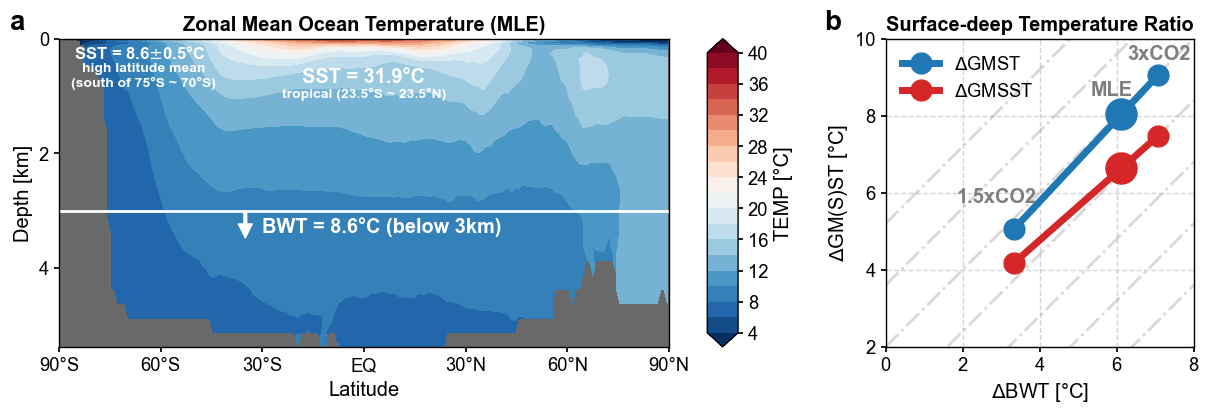

Figure saved at: "../figs/Fig.04.pdf"


In [11]:
from matplotlib.lines import Line2D

x4c.set_style('journal_spines', font_scale=1.2)
fig, ax = x4c.visual.subplots(
    figsize=(15, 4),
    nrow=1, ncol=3,
    hspace=0.3, wspace=0.1,
    ax_loc={
        'temp_yz': (0, slice(0, 2)),
        'ratio': (0, slice(-1, None)),
    },
    annotation=True, annotation_separate=True,
    annotation_kws={
        'temp_yz': {'loc_x': -0.08, 'style': ''},
        'ratio': {'loc_x': -0.2, 'style': ''},
    },
)

TEMP['mle'].x.zm.x.plot(
    levels=np.linspace(4, 40, 19),
    cbar_kwargs={
        'ticks': np.linspace(4, 40, 10),
        'label': 'TEMP [°C]',
    },
    ax=ax['temp_yz'],
)
ax['temp_yz'].grid(False)
ax['temp_yz'].set_title('Zonal Mean Ocean Temperature (MLE)', weight='bold')
ax['temp_yz'].text(
    -30, 3.1e5, f'BWT = {BWT:.1f}°C (below 3km)',
    color='white', weight='bold', ha='left', va='top',
)
ax['temp_yz'].axhline(y=3e5, color='white', lw=2)
ax['temp_yz'].annotate(
    '', xy=(-35, 3.5e5), xytext=(-35, 3e5),
    arrowprops=dict(
        facecolor='white', edgecolor='white',
        shrink=0.05, width=2,
        headwidth=10, headlength=10,
    ),
)
ax['temp_yz'].text(
    -66, 1e4, fr'SST = {np.mean(SST_so):.1f}$\pm${np.std(SST_so):.1f}°C',
    color='white', weight='bold',
    ha='center', va='top', fontsize=12,
)
ax['temp_yz'].text(
    -65, 4e4, 'high latitude mean\n(south of 75°S ~ 70°S)',
    color='white', weight='bold',
    ha='center', va='top', fontsize=10,
)

ax['temp_yz'].text(
    0, 5e4, fr'SST = {SST_tropical:.1f}°C',
    color='white', weight='bold',
    ha='center', va='top',
)
ax['temp_yz'].text(
    0, 8.5e4, 'tropical (23.5°S ~ 23.5°N)',
    color='white', weight='bold',
    ha='center', va='top', fontsize=10,
)

for i in range(-5, 3):
    gap = 0.2
    ax['ratio'].plot([0, 1], [0+gap*i, 1+gap*i], transform=ax['ratio'].transAxes, color='gray', ls='-.', alpha=0.3)

ax['ratio'].plot(
    [df_eq_bwt.loc['1.5x', 'dBWT'], df_eq_bwt.loc['3x', 'dBWT']],
    [df_eq_gmst.loc['1.5x', 'dGMST'], df_eq_gmst.loc['3x', 'dGMST']],
    marker='o', markersize=15, lw=5, color='tab:blue', label=r'$\Delta$GMST',
)

ax['ratio'].plot(
    [df_eq_bwt.loc['1.5x', 'dBWT'], df_eq_bwt.loc['3x', 'dBWT']],
    [df_eq_gmsst.loc['1.5x', 'dGMSST'], df_eq_gmsst.loc['3x', 'dGMSST']],
    marker='o', markersize=15, lw=5, color='tab:red', label=r'$\Delta$GMSST',
)
ax['ratio'].scatter(
    df_CO2pdf.loc[idx, 'dBWT'],
    df_CO2pdf.loc[idx, 'dGMST'],
    color='tab:blue',
    marker='o',
    s=500,
    zorder=99,
)

ax['ratio'].scatter(
    df_CO2pdf.loc[idx, 'dBWT'],
    df_CO2pdf.loc[idx, 'dGMSST'],
    color='tab:red',
    marker='o',
    s=500,
    zorder=99,
)

ax['ratio'].text(df_CO2pdf.loc[idx, 'dBWT']-0.8, df_CO2pdf.loc[idx, 'dGMST']+0.5, 'MLE', color='tab:gray', weight='bold')
ax['ratio'].text(df_eq_bwt.loc['3x', 'dBWT']-0.8, df_eq_gmst.loc['3x', 'dGMST']+0.4, '3xCO2', color='tab:gray', weight='bold')
ax['ratio'].text(df_eq_bwt.loc['1.5x', 'dBWT']-1.5, df_eq_gmst.loc['1.5x', 'dGMST']+0.7, '1.5xCO2', color='tab:gray', weight='bold')

ax['ratio'].set_title('Surface-deep Temperature Ratio', weight='bold')
ax['ratio'].set_ylabel(r'$\Delta$GM(S)ST [°C]')
ax['ratio'].set_xlabel(r'$\Delta$BWT [°C]')
ax['ratio'].set_aspect('equal')
ax['ratio'].set_ylim(2, 10)
ax['ratio'].set_xlim(0, 8)
ax['ratio'].set_yticks(np.linspace(2, 10, 5))
ax['ratio'].set_xticks(np.linspace(0, 8, 5))
ax['ratio'].legend(loc='upper left')


x4c.showfig(fig)
x4c.savefig(fig, '../figs/Fig.04.pdf')